In [1]:
import re
import time
import datetime

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from dataset import engine, Churn, Engagement, RFM
from models import MyRFClassifier, MyRFRegressor
from configs import Config
from myutils import show_cm, show_feature_importance

In [2]:
# config = Config(
# 	RANDOM_STATE=42,
# 	TASK = 'regression',
# 	DATASET='engagement', X_COL = 'market', Y_COL = 'clickthroughrate',
# 	CRITERION='gini', 
# 	MAX_DEPTH=3,
# 	BASE_SCORE=0.5, 
# 	BOOSTER='gbtree',
# 	N_ESTIMATORS=100,
# 	OBJECTIVE='reg:squarederror',
# 	LR=1e-04
# )
# from xgboost import XGBClassifier,  XGBRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import classification_report, mean_squared_error
# # xgr = XGBClassifier(n_estimators=400, max_depth = 12, random_state=45)
# # xgr = XGBRegressor(n_estimators=400, max_depth = 12, random_state=45)
# xgr = Ridge(alpha=1)

# X_train, X_test, y_train, y_test = Engagement(engine, config.TASK, config.X_COL, config.Y_COL).get_Dataset()
# # pd.concat([X_train, y_train], axis=1)
# model = xgr.fit(X_train, y_train); print(model)
# y_pred = model.predict(X_test)
# # cr = classification_report(y_test, y_pred); print(cr)
# mse = mean_squared_error(y_test, y_pred); 
# print(mse); 
# print(pd.DataFrame({'y_test': y_test.values.reshape(-1,), 'y_pred': y_pred.reshape(-1,)}))
# # impt = {c:i for i, c in zip(model.feature_importances_, X_train.columns)}; print(impt)

In [2]:
def train(config):
	if config.DATASET == 'churn':
		X_train, X_test, y_train, y_test = Churn(engine, config.X_COL).get_Dataset()
	elif config.DATASET == 'creditcard':
		X_train, X_test, y_train, y_test = CreditCard(engine, config.X_COL).get_Dataset()
	elif config.DATASET == 'engagement':
		X_train, X_test, y_train, y_test = Engagement(engine, config.TASK, config.X_COL, config.Y_COL).get_Dataset()
		# X_train, X_test = X_train[['adspend']], X_test[['adspend']]
		# print(pd.concat([X_train, y_train], axis=1))
	elif config.DATASET == 'RFM':
		X_train, X_test, y_train, y_test = RFM(engine, config.X_COL, config.Y_COL).get_Dataset()

	# print(pd.concat([X_train, y_train], axis=1))
	metrics = {}
	clf = None
	# Evaluate
	if config.TASK == 'classification':
		# Training
		clf = MyRFClassifier(config)
		clf.fit(X_train,y_train)
		y_pred = clf.predict(X_test)
		# Predict
		cm, cr = clf.evaluate(y_test, y_pred)
		
		metrics['cm'] = cm
		metrics['cr'] = cr
		
	elif config.TASK == 'regression':
		clf = MyRFRegressor(config)
		clf.fit(X_train,y_train)
		y_pred = clf.predict(X_test)
		
		ys = pd.DataFrame({'y_test': y_test.values.reshape(-1,), 'y_pred': y_pred})
		mse, mae = clf.evaluate(y_test, y_pred)
		metrics['mse'] = mse
		metrics['mae'] = mae
		metrics['ys'] = ys
	
	impt = clf.get_feature_importances()
	impt = {c:i for i, c in zip(impt, X_train.columns)}
	fig = show_feature_importance(clf, X_train)
	
	return metrics

# Churn

In [3]:
# Trying out grid search for XGRFClassifier
param_grid = {
    'max_depth': [3, 4, 5],              # Testing around the specified max_depth of 3
    'learning_rate': [1e-4, 1e-3, 1e-2], # Centered around the specified LR of 1e-4
    'n_estimators': [500, 1000, 1500],   # Starting with the specified value of 1000
    'base_score': [0.4, 0.5, 0.6],       # Variations around the base_score of 0.5
    'booster': ['gbtree'],               # Fixed as specified
    'objective': ['binary:logistic'],    # Fixed as specified for binary classification
    'criterion': ['gini', 'entropy'],    # Exploring both options as specified with gini
    'subsample': [0.8, 0.9, 1.0],        # Common subsampling ratios for regularization
    'colsample_bytree': [0.7, 0.8, 1.0]  # Regularization around feature usage per tree
}

In [4]:
X_train, X_test, y_train, y_test = Churn(engine, None).get_Dataset()

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRFClassifier
xgb = XGBRFClassifier(eval_metric="mlogloss", use_label_encoder=False)
# Initialize GridSearchCV with 5-fold cross-validation
grid_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 1.0, 'objective': 'binary:logistic', 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0001, 'criterion': 'entropy', 'colsample_bytree': 0.7, 'booster': 'gbtree', 'base_score': 0.5}
Best Score: 0.8174420696486357


              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1609
           1       0.76      0.69      0.73      1609

    accuracy                           0.74      3218
   macro avg       0.74      0.74      0.74      3218
weighted avg       0.74      0.74      0.74      3218



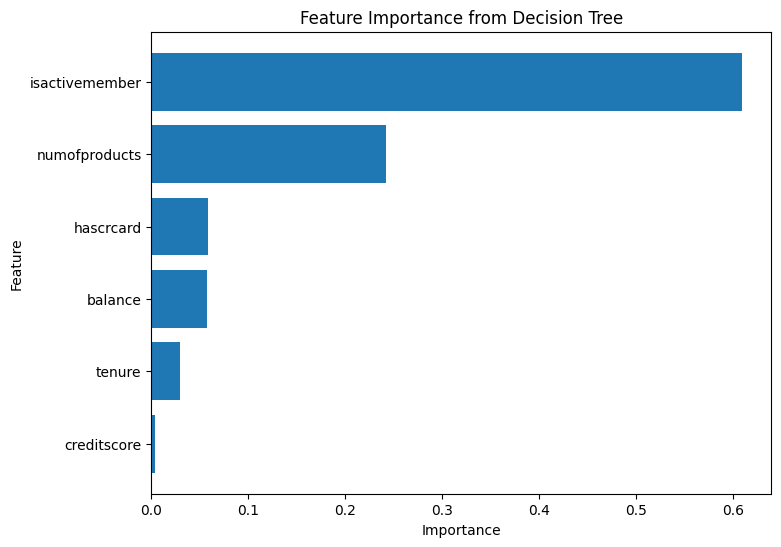

In [8]:
config_ch = Config(
	RANDOM_STATE=42,
	TASK = 'classification',
	DATASET='churn',X_COL = 'market',
	CRITERION='gini', 
	MAX_DEPTH=3,
	BASE_SCORE=0.5, 
	BOOSTER='gbtree',
	N_ESTIMATORS=1000,
	OBJECTIVE='binary:logistic',
	LR=1e-04
)
metrics = train(config_ch)
print(metrics['cr'])

# Marketing/Enagagement

## Conversion Inference

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1406
           1       0.65      0.66      0.66      1406

    accuracy                           0.65      2812
   macro avg       0.65      0.65      0.65      2812
weighted avg       0.65      0.65      0.65      2812



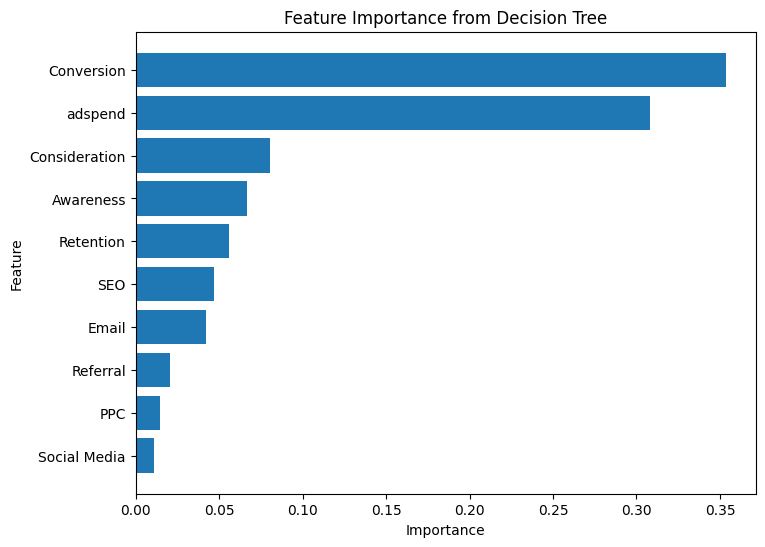

In [32]:
config_eg = Config(
	RANDOM_STATE=42,
	TASK = 'classification',
	DATASET='engagement', X_COL = 'market', Y_COL = 'conversion',
	CRITERION='gini', 
	MAX_DEPTH=3,
	BASE_SCORE=0.5, 
	BOOSTER='gbtree',
	N_ESTIMATORS=1000,
	OBJECTIVE='binary:logistic',
	LR=1e-04
)
metrics = train(config_eg)
print(metrics['cr'])

## Engagement Inference

In [13]:
X_train, X_test, y_train, y_test = Engagement(engine, 'market', y_col = 'emailclicks').get_Dataset()
X_train

,adspend,Email,PPC,Referral,SEO,Social Media,Awareness,Consideration,Conversion,Retention
1467,0.564680,0,0,0,0,1,0,0,1,0
5768,0.537901,0,1,0,0,0,0,0,1,0
5714,0.386740,0,0,0,1,0,0,0,1,0
1578,0.423581,0,0,0,0,1,0,0,0,1
6958,0.101410,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
5226,0.286938,0,1,0,0,0,0,0,1,0
5390,0.664779,1,0,0,0,0,1,0,0,0
860,0.429945,0,1,0,0,0,0,1,0,0
7603,0.670858,0,0,1,0,0,1,0,0,0


In [30]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 5],

}

# Initialize the XGBRegressor with fixed parameters
model = XGBRFRegressor(
    objective='reg:squarederror',
    random_state=42,
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use an appropriate scoring for regression
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 5}
Best Score: -0.10552378278903227


{'mse': 0.10214220204588813, 'mae': 0.27931718766689295, 'ys':         y_test    y_pred
0     0.444444  0.497431
1     0.111111  0.497431
2     0.222222  0.497431
3     1.000000  0.497431
4     0.222222  0.497431
...        ...       ...
1595  0.666667  0.497431
1596  0.222222  0.497431
1597  0.444444  0.497431
1598  0.111111  0.497431
1599  0.444444  0.497431

[1600 rows x 2 columns]}


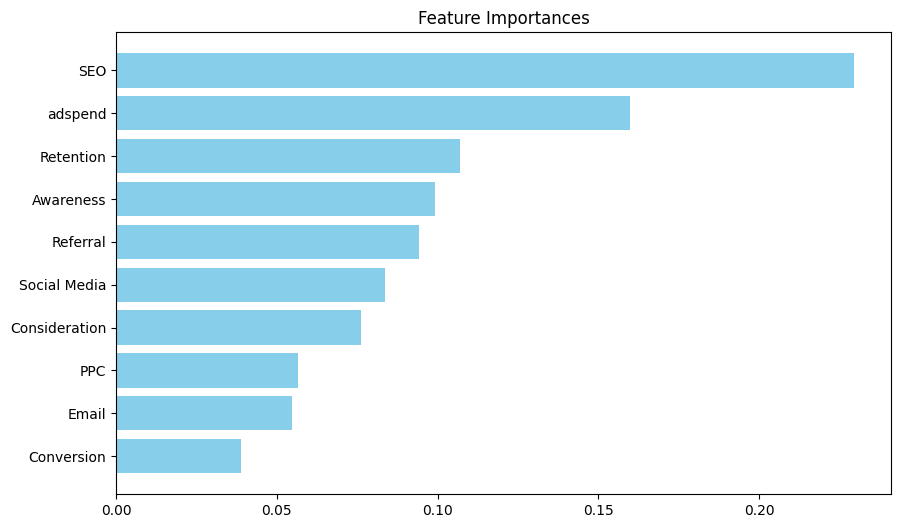

In [14]:
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the XGBRFRegressor with parameters
clf = XGBRFRegressor(
    random_state=42,
    max_depth=3,
    n_estimators=150,
    objective='reg:squarederror',
    learning_rate=1e-5,
    reg_alpha=1,
    reg_lambda=5
)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Store metrics in a dictionary
metrics = {
    'mse': mse,
    'mae': mae,
    'ys': pd.DataFrame({'y_test': y_test.to_numpy().reshape(-1), 'y_pred': y_pred})
}

# Display metrics
print(metrics)

# Feature importance
feature_importances = clf.feature_importances_
impt = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}

# Plot feature importances
def show_feature_importance(importances, columns):
    fig, ax = plt.subplots(figsize=(10, 6))
    sorted_idx = importances.argsort()
    ax.barh(columns[sorted_idx], importances[sorted_idx], color="skyblue")
    ax.set_title("Feature Importances")
    plt.show()

show_feature_importance(clf.feature_importances_, X_train.columns)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1}
Best Cross-Validation Score (MSE): 0.10040780168781575
Test Set Metrics: {'mse': 0.10220761124320114, 'mae': 0.27946732966229315, 'ys':         y_test    y_pred
0     0.444444  0.499558
1     0.111111  0.500306
2     0.222222  0.497773
3     1.000000  0.497787
4     0.222222  0.497628
...        ...       ...
1595  0.666667  0.499837
1596  0.222222  0.499140
1597  0.444444  0.499542
1598  0.111111  0.488463
1599  0.444444  0.507955

[1600 rows x 2 columns]}


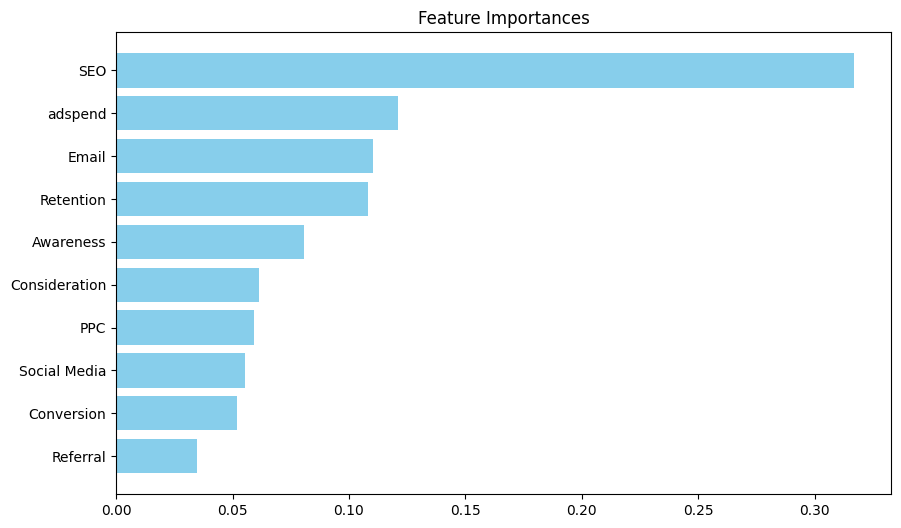

In [15]:
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 5],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# Initialize the XGBRFRegressor
model = XGBRFRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',  # Scoring metric for regression
    n_iter=20,  # Number of different combinations to try
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score (MSE):", -random_search.best_score_)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Store metrics in a dictionary
metrics = {
    'mse': mse,
    'mae': mae,
    'ys': pd.DataFrame({'y_test': y_test.to_numpy().reshape(-1), 'y_pred': y_pred})
}

# Display metrics
print("Test Set Metrics:", metrics)

# Feature importance
feature_importances = best_model.feature_importances_
impt = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}

# Plot feature importances
def show_feature_importance(importances, columns):
    fig, ax = plt.subplots(figsize=(10, 6))
    sorted_idx = np.argsort(importances)
    ax.barh(columns[sorted_idx], importances[sorted_idx], color="skyblue")
    ax.set_title("Feature Importances")
    plt.show()

show_feature_importance(feature_importances, X_train.columns)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'bootstrap': [True, False],           # Whether to use bootstrap samples
    'max_samples': [None, 0.8, 0.9]       # Proportion of the dataset to sample for training each tree
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring for regression
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", -grid_search.best_score_)  # Remember to negate for MSE


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_samples': 0.9, 'min_samples_split': 10}
Best Cross-Validation Score: 0.10174584143821137


Mean Squared Error: 0.1030
Mean Absolute Error: 0.2798
         Feature  Importance
0        adspend    0.800545
6      Awareness    0.026656
9      Retention    0.026610
4            SEO    0.024220
7  Consideration    0.024028
8     Conversion    0.022683
2            PPC    0.021246
3       Referral    0.018652
5   Social Media    0.018548
1          Email    0.016812


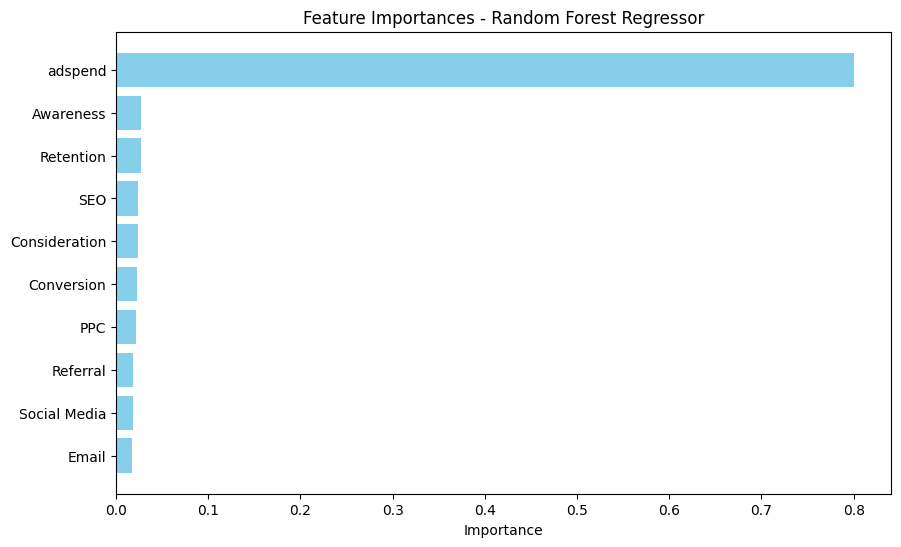

In [28]:
# Initialize the RandomForestRegressor with the given hyperparameters
rf_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    max_samples=0.9,
    min_samples_split=10,
    random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions (optional, for evaluation)
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

# Plot feature importances
def plot_feature_importance(df):
    plt.figure(figsize=(10, 6))
    plt.barh(df['Feature'], df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances - Random Forest Regressor')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

plot_feature_importance(feature_importance_df)

In [4]:
# config_eg = Config(
# 	RANDOM_STATE=42,
# 	TASK = 'regression',
# 	DATASET='engagement', X_COL = 'market', Y_COL = 'emailclicks',
# 	CRITERION='entropy', 
# 	MAX_DEPTH=3,
# 	BASE_SCORE=0.5, 
# 	BOOSTER='gbtree',
# 	N_ESTIMATORS=150,
# 	OBJECTIVE='reg:squarederror',
# 	LR=1e-05,
#     REG_ALPHA = 1,
#     REF_LAMBDA = 5,
# )
# metrics = train(config_eg)
# print(metrics)

AttributeError: 'Config' object has no attribute 'REG_LAMBDA'

# RFM

              precision    recall  f1-score   support

           0       0.20      0.08      0.12      5139
           1       0.21      0.22      0.21      5139
           2       0.23      0.74      0.35      5139
           3       0.19      0.06      0.09      5139
           4       0.30      0.25      0.27      5139
           5       0.22      0.20      0.21      5139
           6       0.22      0.11      0.15      5139
           7       0.56      0.70      0.63      5139
           8       0.24      0.14      0.17      5139
           9       0.27      0.26      0.27      5139

    accuracy                           0.28     51390
   macro avg       0.26      0.28      0.25     51390
weighted avg       0.26      0.28      0.25     51390



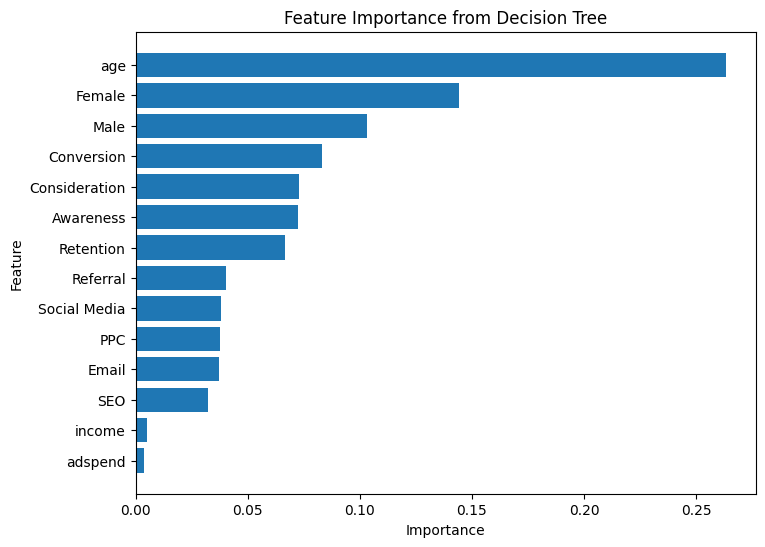

In [7]:
config_rfm = Config(
	RANDOM_STATE=42,
	TASK = 'classification',
	DATASET='RFM', X_COL = 'market', Y_COL = 'segment',
	CRITERION='gini', 
	MAX_DEPTH=None,
	BASE_SCORE=0.5, 
	BOOSTER='gbtree',
	N_ESTIMATORS=500,
	OBJECTIVE='multi:softmax',
	LR=1e-04	
)
metrics = train(config_rfm)
print(metrics['cr'])